# Etude Snorkel / Extration de partenariats d'entreprises
Pour ce projet, nous allons essayer d'extraire des relations de partenariats économiques entre des entreprises depuis des articles. <br/>
Le but étant de comprendre l'utilisation de snorkel.

Nous allons découper notre traitement dans 3 notebooks (chacun correspondant à une étape du pipeline `Snorkel` :
1. Preprocessing
2. Training
3. Evaluation

## Partie II: Génération et modélisation de "_noisy_" labels contenant du bruit

Dans ce notebook, nous allons écrire nos **fonctions de labelisation** pour étiquetter nos données.
Comme ces `Labeling functions` ne seront pas parfaites, nous allons modéliser leur précision avec un modèle _generative_ que `Snorkel` nous permettra d'appliquer.

Nous les utiliserons pour produire un ensemble de label pour nos données d'entrainement. Ces données bien que contenant du bruit, pourront ensuite être appliquer à un modèle de classification.

***

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.viewer import SentenceNgramViewer
from snorkel.lf_helpers import test_LF
from snorkel.annotations import load_gold_labels
from snorkel.annotations import LabelAnnotator
from snorkel.learning import GenerativeModel
from snorkel.annotations import save_marginals

from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,get_text_splits,
    contains_token, rule_text_btw, rule_text_in_span
)

from lib.scoring import *
from lib.lf_factories import *

session = SnorkelSession()

# I. Préparation des données

## 1. Notre schéma

On initialise de nouveau notre relation de partenariat entre 2 entreprises

In [2]:
Partner = candidate_subclass('Partner', ['company1', 'company2'])

## 2. Chargement de notre jeu de données de _development_

Nous chargeons les données qui ont été labelisées manuellement et qui font parties de notre jeu de développement (split = 1)

In [3]:
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

In [4]:
dev_cands   = session.query(Partner).filter(Partner.split == 1).all()

## 3. Data exploration

Analysons nos données pour nous aider à créer les fonctions de labeling.

In [5]:
# load our list of training & development candidates
train_cands = session.query(Partner).filter(Partner.split == 0).all()
dev_cands   = session.query(Partner).filter(Partner.split == 1).all()

SentenceNgramViewer(train_cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

SentenceNgramViewer(cids=[[[178, 179, 180, 181, 182, 183, 859, 860, 861, 862, 863, 959, 960, 961, 962, 1054, 1…

# II. Ecriture des fonctions de labelisation (`Labeling Function`)

`get_left_tokens(c, window=3, attrib='words', n_max=1, case_sensitive=False)
get_right_tokens(c, window=3, attrib='words', n_max=1, case_sensitive=False)
get_between_tokens(c, attrib='words', n_max=1, case_sensitive=False)
get_text_between(c)
get_tagged_text(c)
get_text_split(c)
contains_token`



### Métriques de nos Labeling Function

####  Coverage
C'est le nombre de candidats labelisés par notre LF sur un jeu de données (entrainement).

####  Precision / Recall / F1
Métriques standard pour les classification : précision, rappel, F1-score

In [6]:
# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

## 1. Concurrences

In [7]:
# OK
# search between candidates, compet token for words like (competition, compete, competitive, ...)
def LF_compete(c):
    return -1 if re.search(r'compet', get_text_between(c), flags=re.I) else 0
   
labeled = coverage(session, LF_compete, split=0)
tp, fp, tn, fn = error_analysis(session, LF_compete, split=1, gold=L_gold_dev)

Coverage: 1.18% (29/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 1 | FN: 0



In [8]:
competitors = {'competitor', 'competitors', 'competitive', 'competitives','competition', 'competitions' }
def LF_competitors(c):
    if len(competitors.intersection(get_right_tokens(c[1], window=10))) > 0 :
        return -1
    elif len(competitors.intersection(get_left_tokens(c[0], window=10))) > 0 :
        return -1
    else :
        return 0

labeled = coverage(session, LF_competitors, split=2)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_competitors, split=1, gold=L_gold_dev)
SentenceNgramViewer(fn, session, n_per_page=1)

Coverage: 2.63% (8/304)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [9]:
def LF_such_as(c) :
    return -1 if re.search(r'such as.{0,30}{{A}}.{0,30}',get_tagged_text(c) , re.I) else 0

labeled = coverage(session, LF_such_as, split=0)
tp, fp, tn, fn = error_analysis(session, LF_such_as, split=1, gold=L_gold_dev)
SentenceNgramViewer(fn, session, n_per_page=1)

Coverage: 0.57% (14/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 14 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [10]:
against = ['alternative(s)?', 'vs', 'rival(s)?', 'versus', 'surpass(es|ed)?' , 'competitor(s)?', 'leaders ']
def LF_against(c):
    return -1 if re.search(r'{{A}}.{0,50} ' + ltp(against) + '.{0,50}{{B}}',get_tagged_text(c) , re.I) else 0

labeled = coverage(session, LF_against, split=0)
tp, fp, tn, fn = error_analysis(session, LF_against, split=1, gold=L_gold_dev)
SentenceNgramViewer(fn, session, n_per_page=1)

Coverage: 0.65% (16/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 3 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [11]:
## OK
####
players = {'players', 'vendors',  'major', 'main','providers', 'provide','provides','comparison', 'compare', 'compares'}
def LF_players(c) :
    if len(players.intersection(get_left_tokens(c[0], window=30))) > 0 :
        return -1 
    elif len(players.intersection(get_right_tokens(c[1], window=30))) > 0 :
        return -1
    else :
        return 0

labeled = coverage(session, LF_players, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_players, split=1, gold=L_gold_dev)

Coverage: 25.04% (617/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 8 | FN: 1



In [12]:
def LF_comas(c):
    return -1 if re.search(r'{{A}}.{0,10}\,.{0,10}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_comas, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_comas, split=1, gold=L_gold_dev)

Coverage: 10.84% (267/2464)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 14 | FN: 1



## 2. Acquisitions

In [13]:
acquisitions = ['acquir(e|ed|es|ing){1}', 'acquisition','purchase(s|d)?','buy(ing)?', 'bougth', 'parent'] 

def LG_acquisitions_between(c) :
    return -1 if re.search(r'{{A}}.{0,100} ' + ltp(acquisitions) + '.{0,100}{{B}}', get_tagged_text(c), re.I) else 0
     
labeled = coverage(session, LG_acquisitions_between, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LG_acquisitions_between, split=1, gold=L_gold_dev)

Coverage: 1.50% (37/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



In [14]:
def LG_acquisition_before(c) :
    return -1 if 'acquisition' in (get_left_tokens(c[0], window=50, case_sensitive=False)) else 0

labeled = coverage(session, LG_acquisition_before, split=0)
tp, fp, tn, fn = error_analysis(session, LG_acquisition_before, split=1, gold=L_gold_dev)

Coverage: 0.37% (9/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 1 | FN: 0



In [15]:
def LF_slash(c):
    return -1 if re.search(r'{{A}}.{0,2}/.{0,2}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_slash, split=0)
tp, fp, tn, fn = error_analysis(session, LF_slash, split=1, gold=L_gold_dev)

Coverage: 0.20% (5/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



## 3. Alias

In [16]:
#### OK
# same company name
def LG_sameNames(c) :
    c1_name = c.company1.get_span()
    c2_name = c.company2.get_span()
    if c1_name == c2_name:
        return -1
    return 0

labeled = coverage(session, LG_sameNames, split=0)
tp, fp, tn, fn = error_analysis(session, LG_sameNames, split=1, gold=L_gold_dev)

Coverage: 13.76% (339/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 19 | FN: 0



In [17]:
#### OK
def LG_contains(c) :
    c1_name = c.company1.get_span().lower()
    c2_name = c.company2.get_span().lower()
    return -1 if (c1_name in c2_name or c2_name in c1_name) else 0

    
labeled = coverage(session, LG_contains, split=0)
tp, fp, tn, fn = error_analysis(session, LG_contains, split=1, gold=L_gold_dev)
SentenceNgramViewer(fn, session, n_per_page=1)

Coverage: 16.40% (404/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 22 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [18]:
def LG_sigle(c):
    return -1 if re.search(r'{{A}}.{0,5}\({{B}}\)', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LG_sigle, split=0)
#SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LG_sigle, split=1, gold=L_gold_dev)

Coverage: 0.41% (10/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



## 4. Partenariat

In [19]:
# OK
#####
def LF_with_relations(c):
    return 1 if re.search(r'{{A}}.+with.{0,40}{{B}}',get_tagged_text(c) , re.I) else 0
    

def LF_with_relations_and_not_same(c) :
    return 1 if LF_with_relations(c) == 1 and LG_sameNames(c) != -1  else 0

labeled = coverage(session, LF_with_relations_and_not_same, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_with_relations_and_not_same, split=1, gold=L_gold_dev)
SentenceNgramViewer(fp, session, n_per_page=1)

Coverage: 9.82% (242/2464)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 9 | FP: 0 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [20]:
cooperations = ['partner(ed|s|ing|hip|hips)?',
                'collaborat(e|es|ed|ion|ing){1}',
                'work(s,|ed|ing)? ',
                'integrat(e|es|ed,ion){1}',
                'deal(s|t)?',
                'help(s|ed)?',
                'associat(e|es|ed|ing|ion){1}',  
                'relationship(s)?'
                ] 


def LF_cooperations_btw(c):
    return 1 if re.search(r'{{A}}.{0,100} ' + ltp(cooperations) + '.{0,20}{{B}}', get_tagged_text(c), re.I) else 0

def LF_cooperations_btw_and_not_same(c) :
    return 1 if LF_cooperations_btw(c) == 1 and LG_sameNames(c) != -1 else 0

labeled = coverage(session, LF_cooperations_btw_and_not_same, split=0)
tp, fp, tn, fn = error_analysis(session, LF_cooperations_btw_and_not_same, split=1, gold=L_gold_dev)
SentenceNgramViewer(fp, session, n_per_page=1)

Coverage: 4.42% (109/2464)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 5 | FP: 0 | TN: 0 | FN: 0



<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

In [21]:
cooperations = ['partner(ed|s|ing)?', 'partnership(s)?','collaborat(e|es|ed|ion|ing){1}',
                'cooperat(e|es|ed|ion|ing){1}', 'associat(e|es|ed|ing|ion){1}',  'relationship(s)?',
                'work(s,|ed|ing)?'] 


def LF_cooperations_btw(c):
    return 1 if re.search(r'{{A}}.{0,100} ' + ltp(cooperations) + '.{0,100}{{B}}', get_tagged_text(c), re.I) else 0

def LF_cooperations_btw_and_not_same(c) :
    return 1 if LF_cooperations_btw(c) == 1 and LG_sameNames(c) != -1 else 0

labeled = coverage(session, LF_cooperations_btw_and_not_same, split=0)
tp, fp, tn, fn = error_analysis(session, LF_cooperations_btw_and_not_same, split=1, gold=L_gold_dev)

Coverage: 7.35% (181/2464)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.833
Recall               1.0
F1                   0.909
----------------------------------------
TP: 5 | FP: 1 | TN: 0 | FN: 0



In [22]:
### OK
######

relations = ['partner', 'collaborat','cooperat', 
             'associat',  'relation', 'join', 'alliance', 'unit', 'synergy', 'between'] 

def LF_relations_in_sentence(c) :
    return 1 if re.search(r''+ ltp(relations), get_tagged_text(c), re.I) else 0


def LF_relations_in_sentence_and_not_same(c) :
    return 1 if LF_relations_in_sentence(c) == 1 and LG_sameNames(c) != -1  else 0


labeled = coverage(session, LF_relations_in_sentence_and_not_same, split=0)
tp, fp, tn, fn = error_analysis(session, LF_relations_in_sentence_and_not_same, split=1, gold=L_gold_dev)
#SentenceNgramViewer(fp, session, n_per_page=1)

Coverage: 38.56% (950/2464)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.893
Recall               1.0
F1                   0.943
----------------------------------------
TP: 25 | FP: 3 | TN: 0 | FN: 0



In [23]:
def LF_alliances(c) :
    alliances = {'alliance', 'alliances', 'jointly', 'join', 'association', 'associations'}
    if len(alliances.intersection(get_left_tokens(c[0], window=50, case_sensitive=False))) > 0 :
        return 1
    elif len(alliances.intersection(get_right_tokens(c[1], window=50, case_sensitive=False))) > 0 :
        return 1
    else :
        return 0

    
def LF_alliances_and_not_same(c) :
    return 1 if LF_alliances(c) == 1 and LG_sameNames(c) != -1 else 0


labeled = coverage(session, LF_alliances_and_not_same, split=0)
SentenceNgramViewer(labeled, session, n_per_page=1)
tp, fp, tn, fn = error_analysis(session, LF_alliances_and_not_same, split=1, gold=L_gold_dev)

Coverage: 9.05% (223/2464)


<IPython.core.display.Javascript object>

LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 3 | FP: 0 | TN: 0 | FN: 0



In [25]:
def LF_and(c):
    return 1 if re.search(r'{{A}}.{0,15}and.{0,15}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_and, split=0)
tp, fp, tn, fn = error_analysis(session, LF_and, split=1, gold=L_gold_dev)

Coverage: 6.49% (160/2464)
LF Score
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.778
Recall               1.0
F1                   0.875
----------------------------------------
TP: 7 | FP: 2 | TN: 0 | FN: 0



## 5. Procès

In [26]:
trials = [ 'su(ed|ing){1}', 'lawsuit(s)?', 'claim(s|ed)?', 'legal', 'jury', 'court(s)?',
          'patent(s)', 'violate(s|d)?', 'allege(s|d)?', 'law' ] 

def LF_trial_in_sentence(c) :
    return -1 if re.search(r''+ ltp(trials), get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_trial_in_sentence, split=0)
tp, fp, tn, fn = error_analysis(session, LF_trial_in_sentence, split=1, gold=L_gold_dev)

Coverage: 1.91% (47/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 9 | FN: 0



## 6. Clients

In [27]:
### OK
#####

def LF_clients(c):
    clients = { 'by', 'from', 'include'}
    return -1 if len(clients.intersection(get_left_tokens(c[1], window=3))) > 0 else 0


labeled = coverage(session, LF_clients, split=0)
tp, fp, tn, fn = error_analysis(session, LF_clients, split=1, gold=L_gold_dev)

Coverage: 3.86% (95/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 4 | FN: 1



In [28]:
def LF_or(c):
    return -1 if re.search(r'{{A}}.{0,8}or.{0,8}{{B}}', get_tagged_text(c), re.I) else 0

labeled = coverage(session, LF_or, split=0)
tp, fp, tn, fn = error_analysis(session, LF_or, split=1, gold=L_gold_dev)

Coverage: 0.97% (24/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 0.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 0 | FN: 0



In [29]:
def LF_no_relations(c) :
    return -1 if not re.search(r''+ ltp(relations), get_tagged_text(c), re.I) else 0
labeled = coverage(session, LF_no_relations, split=0)
tp, fp, tn, fn = error_analysis(session, LF_no_relations, split=1, gold=L_gold_dev)

Coverage: 54.02% (1331/2464)
LF Score
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 46 | FN: 18



# III. Application de nos fonctions de labelisation

## 1. Préparation des fonctions

On regroupe toutes les fonctions dans une liste.

In [30]:
LFs = [
    #LF_compete,
    #LF_competitors,
    #LF_against,
    #LG_acquisitions_between,
   # LG_acquisition_before,
   # LF_slash,
    #LG_sameNames,
    #LG_contains,
    #LG_sigle,
    LF_with_relations_and_not_same,
    LF_cooperations_btw_and_not_same,
    LF_relations_in_sentence_and_not_same,
    LF_alliances_and_not_same,
    #LF_trial_in_sentence,
    #LF_clients,
    #LF_players,
    LF_and,
   # LF_such_as,
   # LF_or,
    #LF_comas,
    #LF_most,
    LF_no_relations,
]

Ensuite nous appliquons nos LFs sur nos candidats d'entrainement afin de produire un ensemble de labels. 

In [31]:
labeler = LabelAnnotator(lfs=LFs)

## 2. Génération de la matrice de _labels_

In [32]:
%time L_train = labeler.apply(split=0, lfs=LFs, parallelism=1)
print("Train shape :", L_train.shape)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 16.2 s, sys: 382 ms, total: 16.6 s
Wall time: 17.2 s
Train shape : (2464, 6)


In [33]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_with_relations_and_not_same,0,0.098214,0.098214,0.034497
LF_cooperations_btw_and_not_same,1,0.073458,0.073458,0.009334
LF_relations_in_sentence_and_not_same,2,0.385552,0.200081,0.000000
LF_alliances_and_not_same,3,0.090503,0.090503,0.000000
LF_and,4,0.064935,0.064935,0.027597
LF_no_relations,5,0.540179,0.068182,0.068182


# IV. Entrainement du modèle _génératif_

## 1. Entrainement du modèle

In [34]:
gen_model = GenerativeModel()
gen_model.train(L_train, epochs=10, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [35]:
gen_model.weights.lf_accuracy

array([ 0.41813083,  0.42689871,  0.69082831,  0.45546776,  0.38356406,
        0.71939565])

## 2. Application du modèle au jeu d'entrainement

On applique alors notre modèle génératif aux candidats d'entrainements pour avoir leur probabilité de partenariat. Ce vecteur de probabilité est appellé _marginals_ :

In [36]:
train_marginals = gen_model.marginals(L_train)

In [37]:
train_marginals

array([ 0.79925693,  0.89555516,  0.79925693, ...,  0.79925693,
        0.79925693,  0.19173259])

## 3. Analyse de la modèlisation

Distrubution des marginals de nos données d'entrainement.

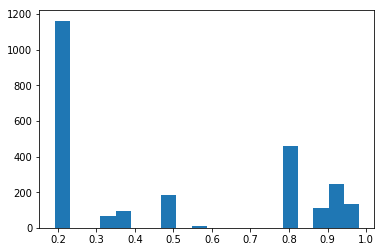

In [38]:
train_marginals = gen_model.marginals(L_train)
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

Statistiques du modèle : 

In [39]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.698344,0.6882,0.697187,0.480229
1,0.705865,0.6871,0.712963,0.487149
2,0.797948,0.7211,0.793870,0.578687
3,0.709635,0.6850,0.711361,0.487742
4,0.693975,0.6921,0.697661,0.483590
5,0.806115,0.7195,0.809524,0.581455


## 4. Sauvegarde des marginals

In [40]:
save_marginals(session, L_train, train_marginals)

Saved 2464 marginals


## 5. Analyse de la performance sur les données de développement

In [41]:
%time L_dev = labeler.apply_existing(split=1, lfs=LFs, parallelism=1)
print("Dev shape :",L_dev.shape)

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1.71 s, sys: 111 ms, total: 1.82 s
Wall time: 2.04 s
Dev shape : (166, 6)


In [42]:
tp, fp, tn, fn  = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.581
Neg. class accuracy: 0.667
Precision            0.379
Recall               0.581
F1                   0.459
----------------------------------------
TP: 25 | FP: 41 | TN: 82 | FN: 18



In [43]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_with_relations_and_not_same,0,0.108434,0.108434,0.048193,9,0,0,0,1.000000,0.706610
LF_cooperations_btw_and_not_same,1,0.090361,0.090361,0.000000,5,1,0,0,0.833333,0.698864
LF_relations_in_sentence_and_not_same,2,0.391566,0.192771,0.000000,25,3,0,0,0.892857,0.801325
LF_alliances_and_not_same,3,0.018072,0.018072,0.000000,3,0,0,0,1.000000,0.715693
LF_and,4,0.126506,0.120482,0.054217,7,2,0,0,0.777778,0.675595
LF_no_relations,5,0.536145,0.102410,0.102410,0,0,18,46,0.718750,0.805767
